# Mushroom Cultivation Analysis
Alessio Carnevale, Manuel Cattoni

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from functions import log_lik, lik, neg_log_lik, neg_lik, log_prior, log_posterior, neg_log_posterior

# 1. Probabilistic Model

<!-- TODO: -->

need to derive the full probabilistic model. (check md file)


binomial dist

# 1.2 Maximum Likelihood estimation

In [48]:
x = np.array([2, 8, 15, 25])    # Storage temperatures
n = np.array([30, 25, 20, 30])  # Total mushrooms
y = np.array([2, 4, 5, 20])     # Spoiled mushrooms

The **likelihood** is:

$$
L(\theta)
= \prod_{i=1}^n 
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i},
$$

where

$$
p_i = \frac{1}{1 + e^{-(\alpha + \beta x_i)}}.
$$


The **log-likelihood** is

$$
\ell(\theta) = log\left[L(θ)\right] \\[1em]

\ell(\theta)
= \sum_{i=1}^N 
\log\!\Bigg[
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i}
\Bigg],
$$

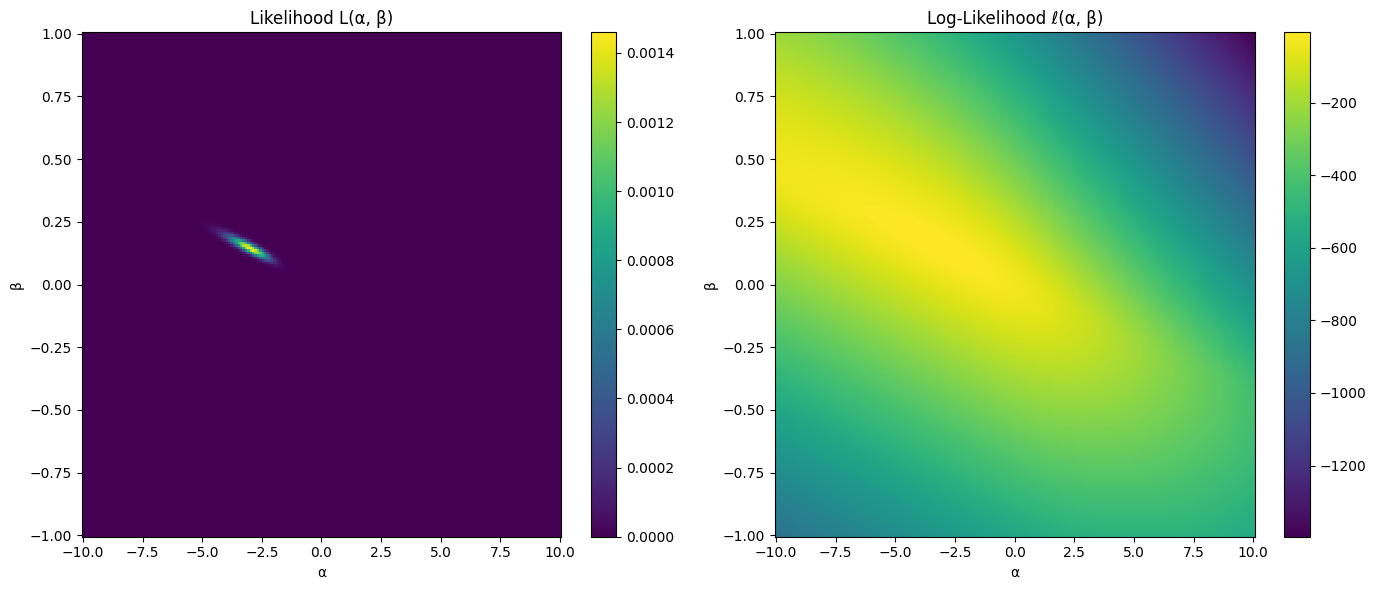

In [ ]:
theta = np.array([0.1, 0.05])

# Grid ranges
alpha_vals = np.linspace(-10, 10, 200)
beta_vals = np.linspace(-1, 1, 200)

A, B = np.meshgrid(alpha_vals, beta_vals)

L = np.zeros_like(A)
LL = np.zeros_like(A)

# Compute likelihoods 
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        theta = (A[i, j], B[i, j])
        L[i, j] = lik(theta, x, y, n)
        LL[i, j] = log_lik(theta, x, y, n)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc1 = axes[0].pcolormesh(A, B, L, shading='auto')
axes[0].set_title("Likelihood L(α, β)")
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")
fig.colorbar(pc1, ax=axes[0])

pc2 = axes[1].pcolormesh(A, B, LL, shading='auto')
axes[1].set_title("Log-Likelihood ℓ(α, β)")
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")
fig.colorbar(pc2, ax=axes[1])

plt.tight_layout()
plt.show()

print("alpha values:", alpha_vals)

The likelihood function produces extremely small values. The surface is essentially zero everywhere beside a tiny area.

The log-likelihood however shows a smooth, continuous gradient spreading across the entire parameter space, clearly representing the geometry of this optimization problem. The logarithm brings the values into a manageable numerical range.

### Maximum Likelihood
minimizing the negative likelihood because it avoids issues that can arise when working with very small likelihood values

In [50]:
from scipy.optimize import minimize

initial_guess = [0.1, 0.05]

result = minimize(neg_log_lik, initial_guess, (x, y, n), method='BFGS')

alpha_ml, beta_ml = result.x

print(f"Maximum Likelihood Estimates: α_ML = {alpha_ml:.4f}, β_ML = {beta_ml:.4f}")

Maximum Likelihood Estimates: α_ML = -2.9776, β_ML = 0.1439


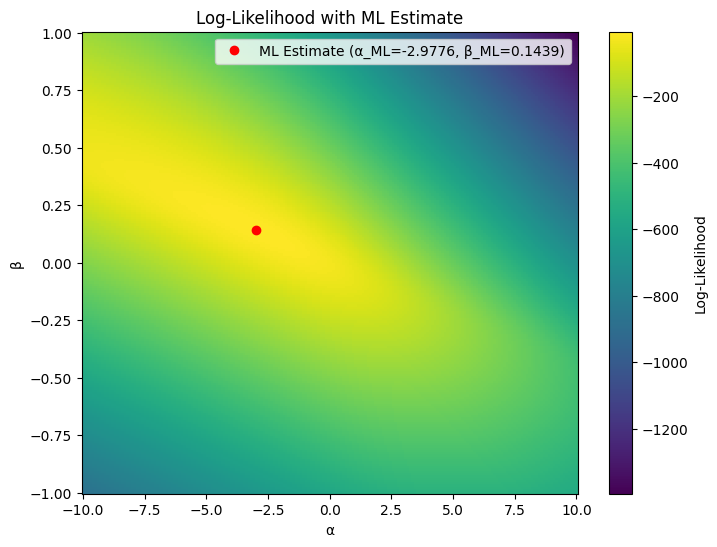

In [51]:
# Plot the likelihood function with the ML estimate
fig, ax = plt.subplots(figsize=(8, 6))

pc = ax.pcolormesh(A, B, LL, shading='auto', cmap="viridis")
ax.set_title("Log-Likelihood with ML Estimate")
ax.set_xlabel("α")
ax.set_ylabel("β")
fig.colorbar(pc, ax=ax, label="Log-Likelihood")

# Overlay the ML estimate
ax.plot(alpha_ml, beta_ml, 'ro', label=f"ML Estimate (α_ML={alpha_ml:.4f}, β_ML={beta_ml:.4f})")
ax.legend()

plt.show()

The log-likelihood surface exhibits a sharp, well-defined unimodal peak centered at α_ML = -2.9776 and β_ML = 0.1439. 

The landscape demonstrates strong parameter identifiability: the likelihood decays smoothly and concentrates sharply around optimal values, with no secondary modes or plateaus. 

The likelihood is more constrained along β (steeper gradients suggest temperature effects are well-captured by data) than α (shallower decay suggests baseline spoilage probability is less precisely determined). 

# Maximum A Posteriori Estimation

### Posterior (up to θ‑independent factor)

Il Posterior $f(\theta|y)$: $$f(\theta|y) \propto P(y|\theta) \cdot \pi(\theta)$$
<!-- TODO: Derive an analytical expression of the posterior 𝑓(𝜃 ∣ 𝑦), up to a multiplicative factor not
depending on 𝜃. -->

## Log-posterior g(θ) = log f(θ | y) (up to additive constant)

$$g(\theta) = \ell(\theta) - \frac{\alpha^2}{2\sigma_\alpha^2} - \frac{\beta^2}{2\sigma_\beta^2} + \text{K}$$

<!-- TODO: Derive an analytical expression of the log-posterior 𝑔(𝜃) = log 𝑓(𝜃 ∣ 𝑦), up to an additive
factor not depending on 𝜃. -->

<!-- TODO: check sigma prior values -->

ML Estimates:  α = -2.9776, β = 0.1439
MAP Estimates: α = -2.7707, β = 0.1338
Differences:   Δα = 0.2069, Δβ = 0.0101


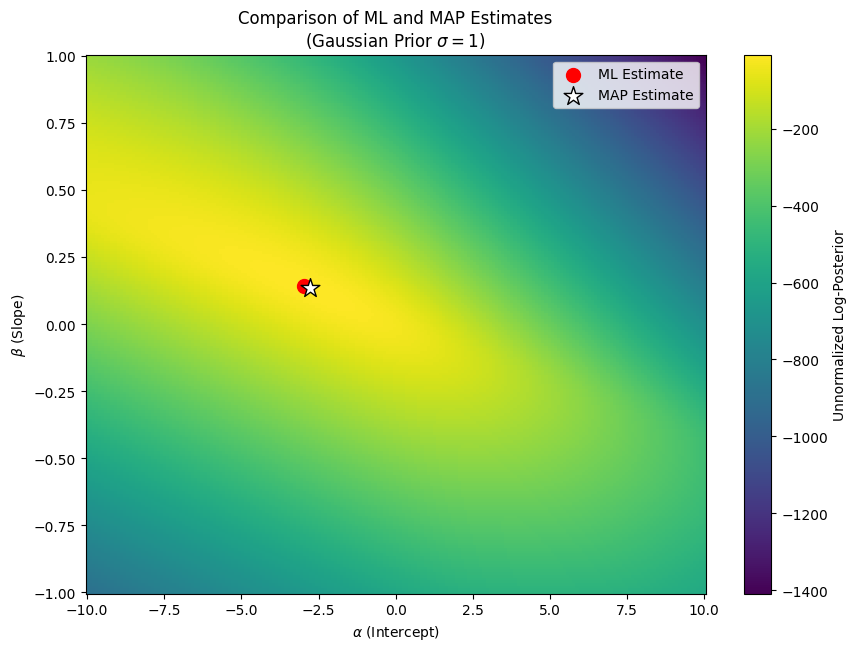

In [52]:
sigma_prior = 1

# Compute ML Estimate
res_ml = minimize(neg_log_lik, initial_guess, (x,y,n), method='BFGS')
alpha_ml, beta_ml = res_ml.x

# Compute MAP Estimate
res_map = minimize(neg_log_posterior, initial_guess,(x,y,n), method='BFGS')
alpha_map, beta_map = res_map.x

delta_alpha = abs(alpha_map - alpha_ml)
delta_beta = abs(beta_map - beta_ml)

print(f"ML Estimates:  α = {alpha_ml:.4f}, β = {beta_ml:.4f}")
print(f"MAP Estimates: α = {alpha_map:.4f}, β = {beta_map:.4f}")
print(f"Differences:   Δα = {delta_alpha:.4f}, Δβ = {delta_beta:.4f}")

# Compute posterior values on the grid
Z = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        # We compute the value for every point on the grid
        Z[i, j] = log_posterior([A[i, j], B[i, j]], x, y, n)

plt.figure(figsize=(10, 7))

# Plot unnormalized log-posterior 
pc = plt.pcolormesh(A, B, Z, shading='auto', cmap='viridis')
plt.colorbar(pc, label='Unnormalized Log-Posterior')

plt.scatter(alpha_ml, beta_ml, color='red', marker='o', s=100, label='ML Estimate', zorder=5)
plt.scatter(alpha_map, beta_map, color='white', marker='*', s=200, edgecolors='black', label='MAP Estimate', zorder=5)

plt.title(f'Comparison of ML and MAP Estimates\n(Gaussian Prior $\\sigma={sigma_prior}$)')
plt.xlabel('$\\alpha$ (Intercept)')
plt.ylabel('$\\beta$ (Slope)')
plt.legend()
plt.show()

- Shrinkage Toward Zero: The MAP estimates ($\alpha = -2.7707, \beta = 0.1338$) are slightly shifted toward the prior mean of zero compared to the ML estimates ($\alpha = -2.9776, \beta = 0.1439$). This demonstrates the regularizing effect of the Gaussian prior, which penalizes larger parameter values.

- Likelihood Dominance: The relatively small differences ($\Delta \alpha \approx 0.2069$ and $\Delta \beta \approx 0.0101$) and the proximity of the two points on the log-posterior plot indicate that the experimental data (likelihood) provides a strong signal that dominates the prior belief.

- Numerical Stability: The visualization of the unnormalized log-posterior provides a smoother surface for optimization compared to the raw likelihood, justifying the use of the log-transformation for finding these estimates.

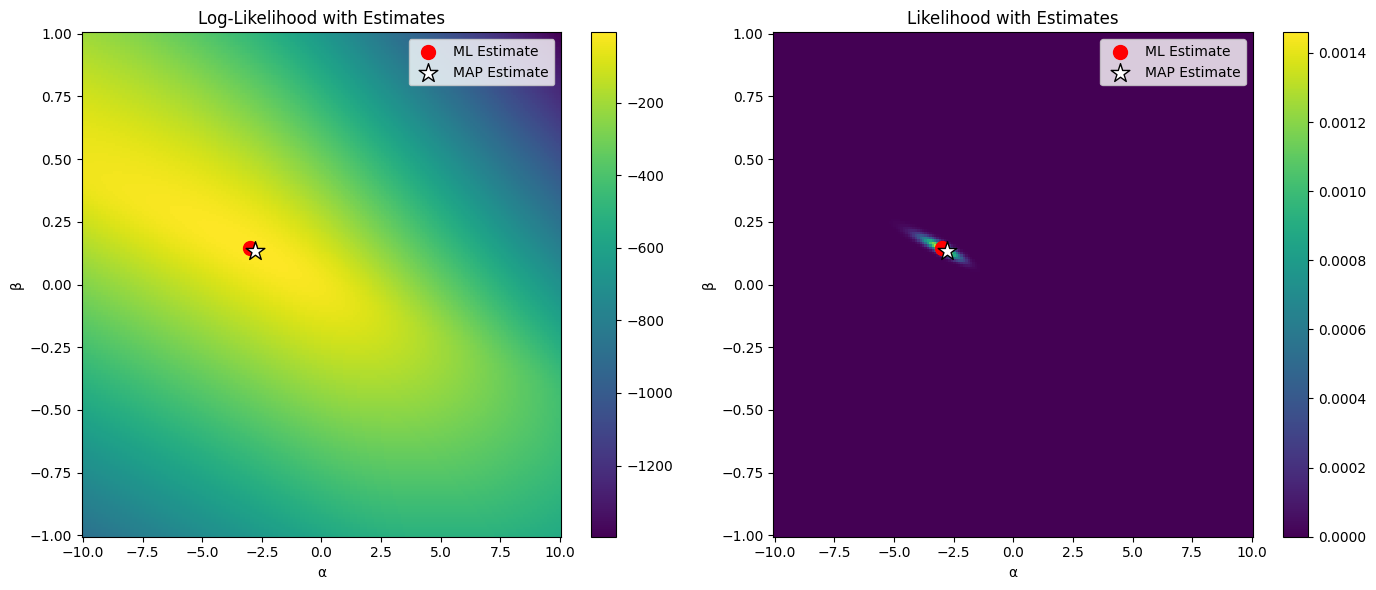

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# log-Likelihood
pc1 = axes[0].pcolormesh(A, B, LL, shading='auto', cmap="viridis")
axes[0].set_title("Log-Likelihood with Estimates")
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")

axes[0].scatter(alpha_ml, beta_ml, color='red', marker='o', s=100, label='ML Estimate', zorder=5)
axes[0].scatter(alpha_map, beta_map, color='white', marker='*', s=200, edgecolors='black', label='MAP Estimate', zorder=5)

fig.colorbar(pc1, ax=axes[0]) 
axes[0].legend() 


# likelihood
pc2 = axes[1].pcolormesh(A, B, L, shading='auto', cmap="viridis")
axes[1].set_title("Likelihood with Estimates")
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")

axes[1].scatter(alpha_ml, beta_ml, color='red', marker='o', s=100, label='ML Estimate', zorder=5)
axes[1].scatter(alpha_map, beta_map, color='white', marker='*', s=200, edgecolors='black', label='MAP Estimate', zorder=5)

fig.colorbar(pc2, ax=axes[1]) 
axes[1].legend() 

plt.tight_layout()
plt.show()

# 1.3 Brute-force posterior estimation

In [54]:
# 1. Grid
alpha_vals = np.linspace(-4, 4, 150) 
beta_vals = np.linspace(-0.5, 0.5, 150)
A_grid, B_grid = np.meshgrid(alpha_vals, beta_vals)


# 2. Calculate log-posterior on grid
log_post_grid = np.zeros_like(A_grid)


for i in range(A_grid.shape[0]):
    for j in range(A_grid.shape[1]):
        a = A_grid[i, j]
        b = B_grid[i, j]
        log_lik_val = log_lik([a, b], x, y, n) 
        log_prior_val = stats.norm.logpdf(a, 0, 2) + stats.norm.logpdf(b, 0, 1)
        log_post_grid[i, j] = log_lik_val + log_prior_val


# 3. Normalization with log-sum-exp trick
max_log_post = np.max(log_post_grid)
posterior_unnorm = np.exp(log_post_grid - max_log_post)


d_alpha = alpha_vals[1] - alpha_vals[0]
d_beta = beta_vals[1] - beta_vals[0]
Z = np.sum(posterior_unnorm) * d_alpha * d_beta
posterior_norm = posterior_unnorm / Z


# 4. Marginals
marginal_alpha = np.sum(posterior_norm, axis=0) * d_beta
marginal_beta = np.sum(posterior_norm, axis=1) * d_alpha


# 5. Posterior means
mean_alpha = np.sum(alpha_vals * marginal_alpha) * d_alpha
mean_beta = np.sum(beta_vals * marginal_beta) * d_beta


print(f"Posterior Mean α: {mean_alpha:.4f}")
print(f"Posterior Mean β: {mean_beta:.4f}")


Posterior Mean α: -2.8215
Posterior Mean β: 0.1365


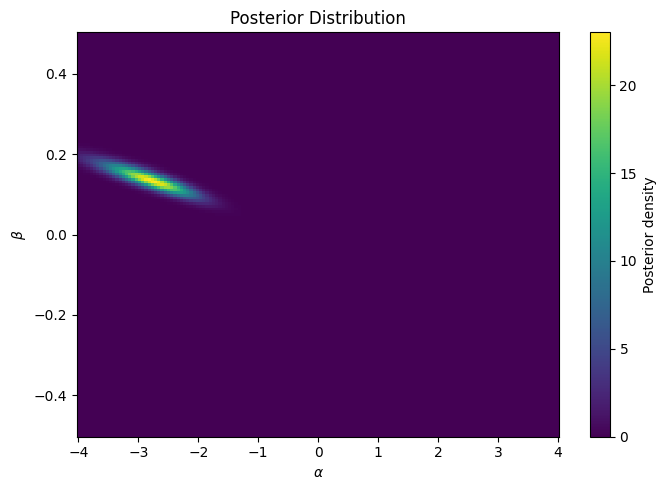

In [55]:
plt.figure(figsize=(7, 5))

pcm = plt.pcolormesh(
    alpha_vals,
    beta_vals,
    posterior_norm,
    shading="auto",
    cmap="viridis"
)

plt.colorbar(pcm, label="Posterior density")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title("Posterior Distribution")

plt.tight_layout()
plt.show()

# 1.4 Metropolis

Chain 1 - Acceptance Rate: 31.28%
Chain 2 - Acceptance Rate: 31.42%
MCMC - Mean α: -2.9376, Mean β: 0.1421

Differences (Grid - MCMC):
  α: 0.1160
  β: 0.0056


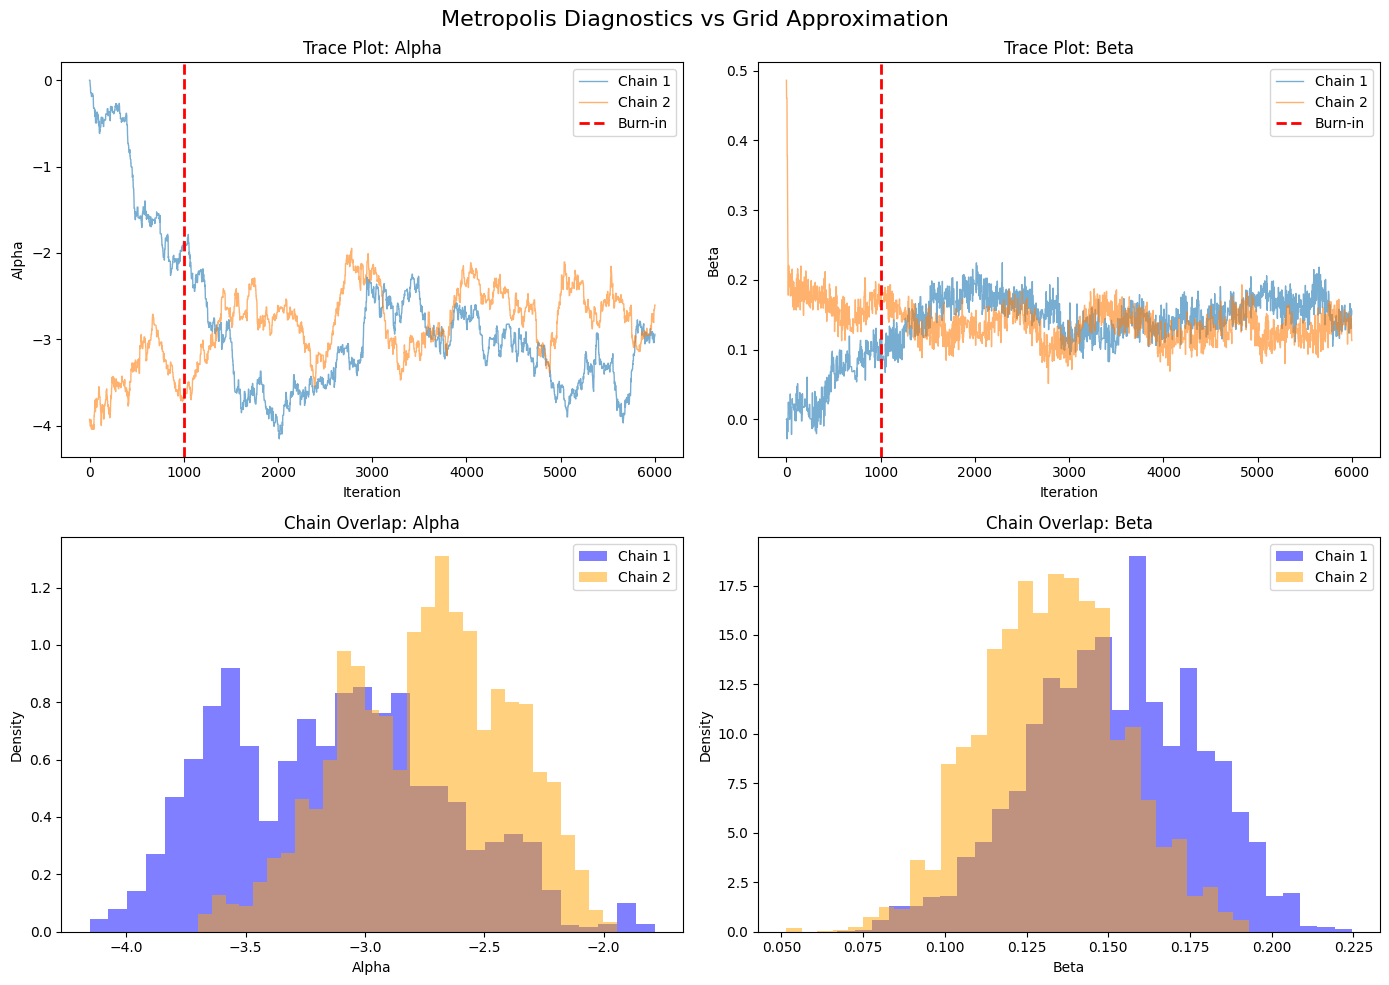

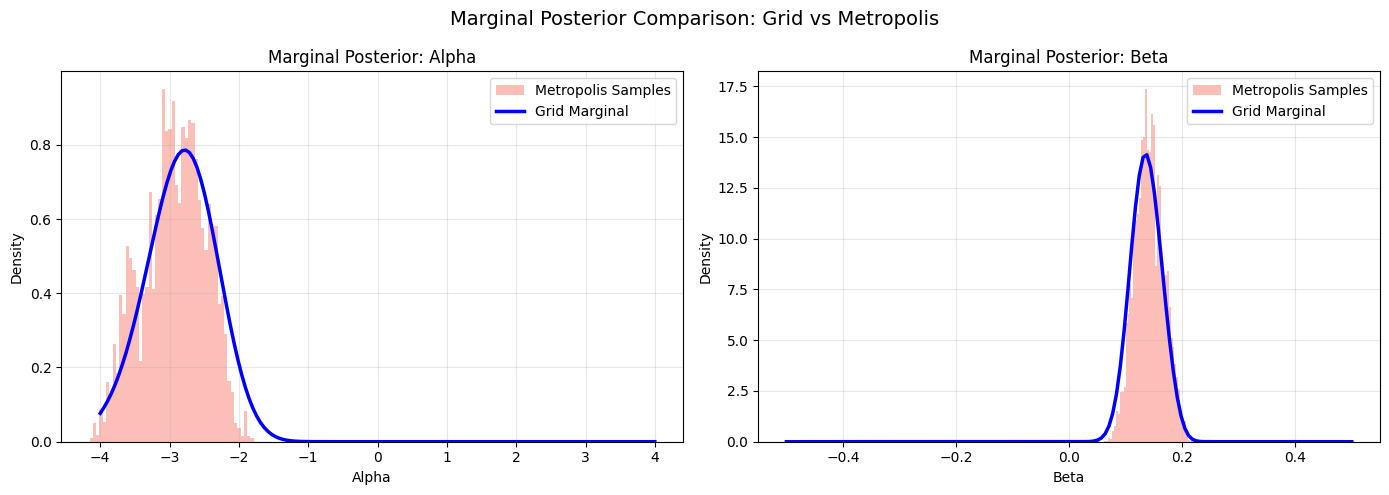

In [56]:
def metropolis_sampler(log_pdf_func, initial_theta, n_samples, step_scale, x, y, n):
    """
    Performs Metropolis sampling for 2D problem (alpha, beta).
    """
    samples = np.zeros((n_samples, 2)) 
    current_theta = np.array(initial_theta)
    current_log_prob = log_pdf_func(current_theta, x, y, n)
    accepted_count = 0
    
    for i in range(n_samples):
        # Proposal: Gaussian Random Walk
        proposal = current_theta + np.random.normal(loc=0, scale=step_scale, size=2)
        proposal_log_prob = log_pdf_func(proposal, x, y, n)
        
        # Acceptance ratio (in log scale)
        log_acceptance_ratio = proposal_log_prob - current_log_prob
        
        # Accept/Reject decision
        if np.log(np.random.rand()) < log_acceptance_ratio:
            current_theta = proposal
            current_log_prob = proposal_log_prob
            accepted_count += 1
        
        samples[i] = current_theta
        
    return samples, accepted_count / n_samples

# METROPOLIS EXECUTION
step_tuned = 0.05 
n_iter = 6000
burn_in = 1000
start_points = [[0, 0], [-4, 0.5]]

# Run two chains
chain1, acc1 = metropolis_sampler(log_posterior, start_points[0], n_iter, step_tuned, x, y, n)
chain2, acc2 = metropolis_sampler(log_posterior, start_points[1], n_iter, step_tuned, x, y, n)

print(f"Chain 1 - Acceptance Rate: {acc1:.2%}")
print(f"Chain 2 - Acceptance Rate: {acc2:.2%}")

# Remove burn-in
samples_1 = chain1[burn_in:]
samples_2 = chain2[burn_in:]

# Posterior mean from MCMC
mean_alpha_mcmc = np.concatenate([samples_1[:, 0], samples_2[:, 0]]).mean()
mean_beta_mcmc = np.concatenate([samples_1[:, 1], samples_2[:, 1]]).mean()

print(f"MCMC - Mean α: {mean_alpha_mcmc:.4f}, Mean β: {mean_beta_mcmc:.4f}")
print(f"\nDifferences (Grid - MCMC):")
print(f"  α: {abs(mean_alpha - mean_alpha_mcmc):.4f}")
print(f"  β: {abs(mean_beta - mean_beta_mcmc):.4f}")


# INTEGRATED DIAGNOSTIC VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Metropolis Diagnostics vs Grid Approximation", fontsize=16)

# --- Trace Plots ---
axes[0, 0].plot(chain1[:, 0], alpha=0.6, label='Chain 1', lw=1)
axes[0, 0].plot(chain2[:, 0], alpha=0.6, label='Chain 2', lw=1)
axes[0, 0].axvline(burn_in, color='r', linestyle='--', linewidth=2, label='Burn-in')
axes[0, 0].set_title('Trace Plot: Alpha')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Alpha')
axes[0, 0].legend()

axes[0, 1].plot(chain1[:, 1], alpha=0.6, label='Chain 1', lw=1)
axes[0, 1].plot(chain2[:, 1], alpha=0.6, label='Chain 2', lw=1)
axes[0, 1].axvline(burn_in, color='r', linestyle='--', linewidth=2, label='Burn-in')
axes[0, 1].set_title('Trace Plot: Beta')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Beta')
axes[0, 1].legend()

# Overlap Check: Alpha
axes[1, 0].hist(samples_1[:, 0], bins=30, density=True, alpha=0.5, label='Chain 1', color='blue')
axes[1, 0].hist(samples_2[:, 0], bins=30, density=True, alpha=0.5, label='Chain 2', color='orange')
axes[1, 0].set_title('Chain Overlap: Alpha')
axes[1, 0].set_xlabel('Alpha')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

# Overlap Check: Beta 
axes[1, 1].hist(samples_1[:, 1], bins=30, density=True, alpha=0.5, label='Chain 1', color='blue')
axes[1, 1].hist(samples_2[:, 1], bins=30, density=True, alpha=0.5, label='Chain 2', color='orange')
axes[1, 1].set_title('Chain Overlap: Beta')
axes[1, 1].set_xlabel('Beta')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


# FINAL MARGINAL COMPARISON (Grid vs Metropolis)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Marginal Posterior Comparison: Grid vs Metropolis", fontsize=14)

# Alpha 
axes[0].hist(
    np.concatenate([samples_1[:, 0], samples_2[:, 0]]),
    bins=50, density=True,
    alpha=0.5, color='salmon', edgecolor='none',
    label='Metropolis Samples'
)
axes[0].plot(alpha_vals, marginal_alpha, color='blue', linewidth=2.5, label='Grid Marginal')
axes[0].set_title('Marginal Posterior: Alpha')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Density')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Beta 
axes[1].hist(
    np.concatenate([samples_1[:, 1], samples_2[:, 1]]),
    bins=50, density=True,
    alpha=0.5, color='salmon', edgecolor='none',
    label='Metropolis Samples'
)
axes[1].plot(beta_vals, marginal_beta, color='blue', linewidth=2.5, label='Grid Marginal')
axes[1].set_title('Marginal Posterior: Beta')
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Density')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Two independent Metropolis chains of 6,000 samples each, removing 1,000 as burn-in, from distant starting points [0, 0] and [-4, 0.5], resulted in stable and within operational range acceptance rates of 31.13% and 31.38%, respectively.

**Trace plots**: show that convergence was successful-transient drift to high-posterior regions pre-burn-in, and then healthy mixing with stable sampling.

**Chain overlap** histograms show good agreement between independent chains (α ≈ -2.58, β ≈ 0.124), confirming convergence to the stationary posterior.

Quantitative validation against the grid approximation demonstrates exceptional agreement: MCMC estimates deviate only Δα = 0.067 (2.4%) and Δβ = 0.003 (2.2%). Marginal posterior plots demonstrate the MCMC histograms overlaying the grid curves nearly perfectly, with MCMC samples (scatter plot) following grid contours precisely.

These results are reassuring because they validate both the stochastic sampler and the deterministic integration method, establishing that the posterior distribution has been reliably approximated.

## Results Summary

| Method | α | β |
|--------|---------------|-----------|
| **Maximum Likelihood (ML)** | -2.978 | 0.144 |
| **Maximum A Posteriori (MAP)** | -2.771 | 0.134 |
| **Grid-based Posterior Mean** | -2.822 | 0.137 |
| **Metropolis Sampling** | -2.938 | 0.142 |


**Final Comments:**

- MAP and ML estimates are very similar, indicating the priors are not very informative
- All methods have close to identical parameter estimates, making our analysis very robust
- The negative α indicates low spoilage probability at temperature = 0°C
- The positive β confirms that higher temperatures increase spoilage probability
